# Pre-process pipeline

## Imports

In [108]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Global variables / settings for this notebook

In [109]:
subject_no = 9

In [110]:
# subject-independant directory and filename of raw-data
input_subject_file = f"..\\data\\raw\\subject-{subject_no}.tsv"
# sample rate of the eye tracker used to gather raw data
sample_rate = 150
# expected logs for one experiment (START_TRIAL {NUM}, FIXATION, PREVIEW, AUDIOSTART, VERBONSET, TARGETONSET, PAUSE)
expected_logs = [64, 64, 64, 64, 64, 64, 0]
# custom fields of log to be copied
fields_to_copy = ["GROUP", "SENTENCE_ID", "SENTENCE", "STIMULUS_NAME", "CONDITION", "AUDIO", "SSTIM_TL", "SSTIM_TR", "SSTIM_BL", "SSTIM_BR", "TARGET_POS", "LOCATION_CUE", "VERB_CUE_TIMING", "VERB_CUE", "TARGET_CUE_TIMING", "TRIAL", "SUBJECT"]

In [111]:
# read data
data = pd.read_csv(input_subject_file, sep="\t", header=0)

# drop unnecessary data
data = data.drop(["TIME_TICK"], axis=1)
data = data.drop(["FPOGX", "FPOGY", "FPOGS", "FPOGD", "FPOGID", "FPOGV"], axis=1)
data = data.drop(["LPOGX", "LPOGY", "LPOGV", "RPOGX", "RPOGY", "RPOGV"], axis=1)
data = data.drop(["LPCX", "LPCY", "LPD", "LPS", "LPV", "RPCX", "RPCY", "RPD", "RPS", "RPV"], axis=1)
data = data.drop(["LEYEX", "LEYEY", "LEYEZ", "LPUPILD", "LPUPILV", "REYEX", "REYEY", "REYEZ", "RPUPILD", "RPUPILV"], axis=1)
data = data.drop(["CX", "CY", "CS"], axis=1)

# display data
pd.set_option("display.max_columns", None)
data.head(5)

,CNT,TIME,BPOGX,BPOGY,BPOGV,USER
0,317632,2148.95679,0.48424,0.34280,1,START_TRIAL 0
1,317633,2148.96313,0.48362,0.35419,1,NaN
2,317634,2148.96997,0.46251,0.39677,1,NaN
3,317635,2148.97681,0.48378,0.40152,1,NaN
4,317636,2148.98340,0.48318,0.41274,1,VAR TRIAL_LOG EVENT=FIXATION;GROUP=WOLF;SENTEN...


## Create plots directory for subject

In [112]:
# Define the folder name
plt_folder_name = f"..\\plots\\subject-{subject_no}"

# Check if the folder exists, if not, create it
if not os.path.exists(plt_folder_name):
    os.makedirs(plt_folder_name)
    print(f"Folder {plt_folder_name} created.")
else:
    print(f"Folder {plt_folder_name} already exists. Skipping...")

plots_folder_name = os.path.abspath(plt_folder_name)

Folder ..\plots\subject-7 already exists. Skipping...


## 0. Dtypes of dataframe
Make sure, that columns have no mixed dtypes

In [113]:
for column in data.columns:
    print(column,":",pd.api.types.infer_dtype(data[column]))

CNT : integer
TIME : floating
BPOGX : floating
BPOGY : floating
BPOGV : integer
USER : string


## 1. Sanity check
### 1.1 Logs

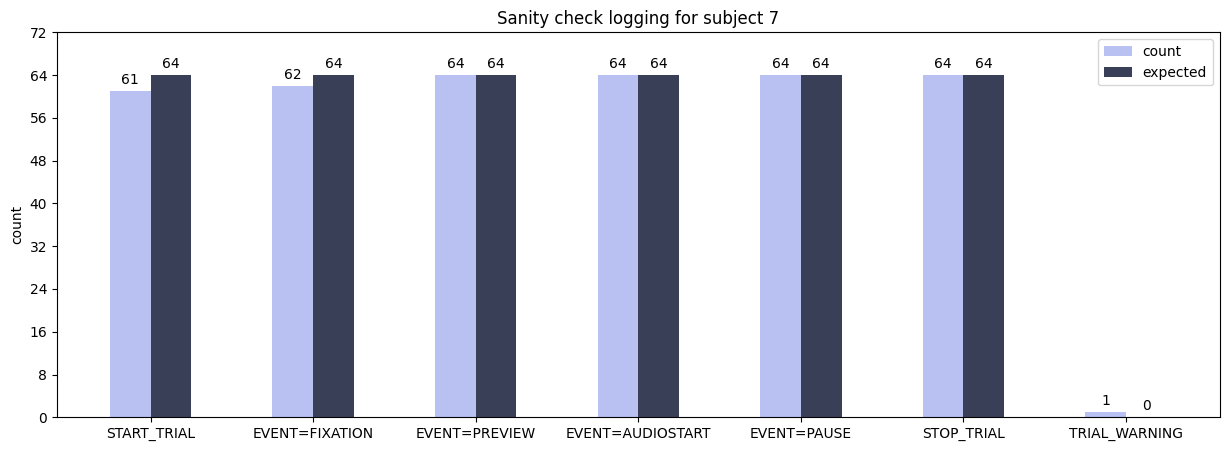

In [114]:
# finds the occurencies of "word" in data
def find_occur(data, word):
    all_text = " ".join(data["USER"].astype(str).values.flatten())
    total_count = all_text.count(word)
    return total_count

# add labels on top of the bars
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate("{}".format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha="center", va="bottom")

# index
log_index = ["START_TRIAL", "EVENT=FIXATION", "EVENT=PREVIEW", "EVENT=AUDIOSTART", "EVENT=PAUSE", "STOP_TRIAL", "TRIAL_WARNING"]
ind = np.arange(len(log_index))

count = []
for log in log_index:
    count.append(find_occur(data, log))

# width of the bars
width = 0.25

# barplot data
logs = pd.DataFrame({"count": count, "expected": expected_logs}, index=log_index)

# plot
fig, ax = plt.subplots(figsize=(15, 5))

count_bar = ax.bar(ind - width/2, count, width, label="count", color="#b8c1f2")
add_bar_labels(count_bar)
expected_bar = ax.bar(ind + width/2, expected_logs, width, label="expected", color="#3a3f58")
add_bar_labels(expected_bar)

# labels and ticks
ax.set_yticks(np.arange(0, np.max(expected_logs)+15, step=8))
ax.set_xticks(ind)
ax.set_xticklabels(log_index)
ax.set_ylabel("count")
ax.set_title(f"Sanity check logging for subject {subject_no}")
ax.legend()

# display plot
plt.show()

# save plot to assets
fig.savefig(f"{plots_folder_name}/1-sanity-logging_events.png")

### 1.2. Time between samples

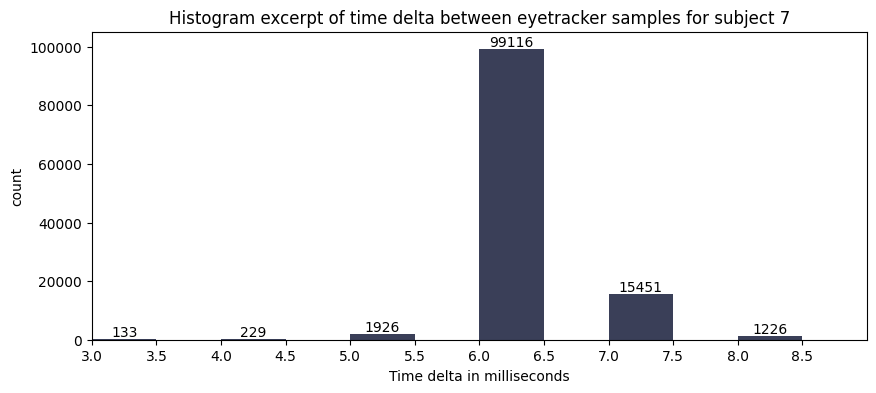

In [115]:
# calculate time between samples (delta) in milliseconds
time_deltas = (data["TIME"].diff() * 1000).fillna(0).astype(int)

# count occurrences of each delta
delta_counts = time_deltas.value_counts()

mn = delta_counts.idxmax()
mn_max = delta_counts.max()
l_dev = mn - 3  
r_dev = mn + 3

# adjust bins as needed
bins= np.arange(l_dev, r_dev, step=0.5)

# plot
fig = plt.figure(figsize=(10, 4))

plt.hist(time_deltas, width=0.5, bins=bins, color="#3a3f58")

# labels and ticks
plt.title(f"Histogram excerpt of time delta between eyetracker samples for subject {subject_no}")
plt.xlabel("Time delta in milliseconds")
plt.ylabel("count")
plt.xlim([l_dev,r_dev])

plt.ylim([0,mn_max+6000])
plt.xticks(bins)

# Calculate bin counts
bin_counts, _ = np.histogram(time_deltas, bins=bins)

# add annotations on top of bars
for i in range(len(bins) - 1):
    if(bin_counts[i] == 0):
        continue
    plt.text((bins[i] + bins[i+1]) / 2, bin_counts[i], str(bin_counts[i]), ha="center", va="bottom", fontsize=10)


# display plot
plt.show()  

# save plot to assets
fig.savefig(f"{plots_folder_name}/1-sanity-hist_time_deltas.png")

## 2. Preporcessing and enhancement of data quality

### 2.1. Interpolation
#### 2.1.1. Implement interpolation

In [116]:
# copy original data, to compare later on with interpolated data
before_interpol_data = data.copy()

# interpolate BPOGX and BPOGY
interp_func_x = interp1d(data["TIME"], data["BPOGX"], kind="linear", fill_value="interpolate")
interp_func_y = interp1d(data["TIME"], data["BPOGY"], kind="linear", fill_value="interpolate")
interp_func_v = interp1d(data["TIME"], data["BPOGV"], kind="linear", fill_value="interpolate")

# generate new evenly spaced time points
t_delta = data["TIME"].max() - data["TIME"].min() 
lin_num = (t_delta * sample_rate).round(0).astype(int)

new_time = np.linspace(data["TIME"].min(), data["TIME"].max(), num=lin_num)

# get interpolated values with new time
new_bpogx = interp_func_x(new_time)
new_bpogy = interp_func_y(new_time)
new_bpogv = interp_func_v(new_time)

# overwrite original dataframe and round like original data
data = pd.DataFrame({})
data["TIME"] = new_time
data["BPOGX"] = new_bpogx.astype(float)
data["BPOGY"] = new_bpogy.astype(float)
data["BPOGV"] = new_bpogv.round(0).astype(int)

print(find_occur(before_interpol_data, "AUDIOSTART"))
# for index, row in before_interpol_data.iterrows():
# #     # if user row has an entry
#     if row["USER"]:
#         # find the index of the nearest time in data
#         time_diff = (data["TIME"] - row["TIME"]).abs()
#         nearest_time_index = time_diff.idxmin()
        
#         print(f"DLT {time_diff}: {data["TIME"]} - {row["TIME"]} // {nearest_time_index}")


#         # copy user cell to data-dataframe
#         data.at[nearest_time_index, "USER"] = str(row["USER"])

def find_nearest_index(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

for index, row in before_interpol_data.iterrows():
    if pd.notna(row["USER"]):  # Check if USER event is present
        nearest_index = find_nearest_index(new_time, row["TIME"])
        # Add or append the event to the USER column
        # if data.at[nearest_index, 'USER'] is None:
        data.at[nearest_index, "USER"] = row["USER"]
        # else:
        #     # If there's already an entry, concatenate the event
        #     data.at[nearest_index, 'USER'] += f"; {row['USER']}"


print(find_occur(data, "AUDIOSTART"))
#! TODO: CORRECT PROBLEM

64
64


#### 2.1.2. Visualize Interpolation 

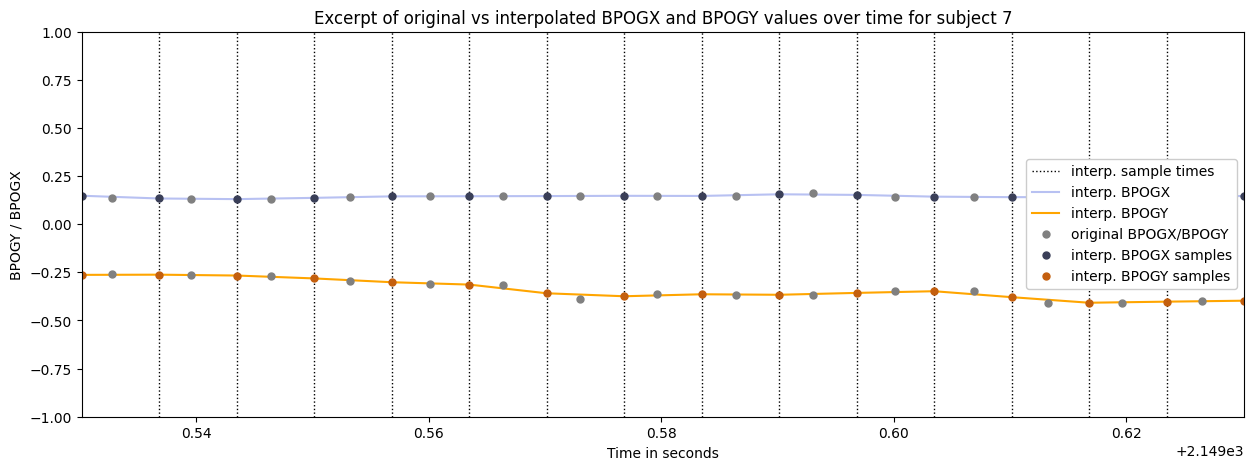

In [117]:
# get a random sample of the dataframe
# ! assuming there are min. 1000 samples
start_time = data["TIME"][random.randint(0,1000)] 
section = (start_time,start_time+0.1)

# plot
fig = plt.figure(figsize=(15, 5))

# mark interpolated time points
avxl_index = False
for index, row in data.iterrows():
    time = row["TIME"]
    if time > section[0] and time < section[1]:
        plt.axvline(x=time, color="black", linestyle=":", linewidth=1, label="interp. sample times" if not avxl_index else "")
        avxl_index = True

# BPOGX/Y interpol.
plt.plot(data["TIME"], data["BPOGX"], "-", label="interp. BPOGX", color="#b8c1f2")
plt.plot(data["TIME"], data["BPOGY"]-1, "-", label="interp. BPOGY", color="orange")

# BPOGX samples
plt.plot(before_interpol_data["TIME"], before_interpol_data["BPOGX"], "o", label="original BPOGX/BPOGY", markersize=5, color="grey")
plt.plot(data["TIME"], data["BPOGX"], "o", label="interp. BPOGX samples", markersize=5, color="#3a3f58")

# BPOGY samples
plt.plot(before_interpol_data["TIME"], before_interpol_data["BPOGY"]-1, "o", markersize=5, color="grey") # shift by 1 for visualisation
plt.plot(data["TIME"], data["BPOGY"]-1, "o", label="interp. BPOGY samples", markersize=5, color="#c45f0e")

# labels and ticks
plt.title(f"Excerpt of original vs interpolated BPOGX and BPOGY values over time for subject {subject_no}")
plt.xlabel("Time in seconds")
plt.ylabel("BPOGY / BPOGX")
plt.xlim((section[0],section[1]))
plt.ylim((-1, 1))
plt.legend(loc="center right", framealpha=1)

# display plot
plt.show()

# save plot to assets
fig.savefig(f"{plots_folder_name}/2-preprocessing-visualized_interpolation.png")

#### 2.1.3. Verify interpolation

In [118]:
# calc time between samples (deltas)
time_deltas = (data["TIME"].diff() * 1000).drop(0).astype(int)

# count occurrences of each delta and print
delta_counts = time_deltas.value_counts()
print(delta_counts)

TIME
6    134016
Name: count, dtype: int64


NOTE: Output should be a pandas Series with only one Value!

## 2.2. Custom Logs

### 2.2.1. Decode custom logs and expand dataframe

Input format for log message in USER-column:
```
VAR TRIAL_LOG <LOGSTING>
VAR TRIAL_LOG EVENT=FIXATION;GROUP=WOLF;SENTENCE_ID=63;... # expample
```
Structure:
```
VAR TRIAL_LOG <KEY>=<VALUE>;<K>=<V>...
```

In [119]:
for index, row in data.iterrows():
    
    # add subject to every row
    data.at[index, "SUBJECT"] = subject_no

    # get loggin row of opengaze data
    inp = str(row["USER"])
    
    if inp.find("TRIAL_LOG") != -1:
        
        cleaned_inp = inp.split("VAR TRIAL_LOG ", maxsplit=2)[1]
        kv_inp = cleaned_inp.split(";")

        # decode key/value-pairs and copy them to column (key) and value (cell)
        for elem in kv_inp:

            key, val = elem.split("=", maxsplit=1)

            data.at[index, key] = val
    
    # other custom logs
    elif inp.find("TRIAL_WARNING") != -1:
        
        data.at[index, "EVENT"] = "WARNING"
        
    elif inp.find("START_TRIAL") != -1:
        
        data.at[index, "EVENT"] = "START_TRIAL"
        data.at[index, "TRIAL"] = int(inp[11:].replace(" ", ""))
    
    elif inp.find("STOP_TRIAL") != -1:
        
        data.at[index, "EVENT"] = "STOP_TRIAL"
        data.at[index, "TRIAL"] = int(inp[11:].replace(" ", ""))

# drop original log column
data.drop(columns=["USER"], inplace=True)

C:\Users\CleresAndreK\AppData\Local\Temp\ipykernel_33580\2842800961.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.at[index, key] = val


### 2.2.2. Calculate VERB- and TARGETONSET and add it to dataframe with corresponding log data

In [120]:
# extend logs with the corresponding events
audio_start_data = data.query("EVENT=='AUDIOSTART'")
print(len(audio_start_data))
for index, row in audio_start_data.iterrows():
    
    sample_time = float(row["TIME"])
    
    delta_verb_onset = float(row["VERB_CUE_TIMING"])/1000
    delta_target_onset = float(row["TARGET_CUE_TIMING"])/1000
    
    time_verb_onset = sample_time + delta_verb_onset
    time_target_onset = sample_time + delta_target_onset
    
    first_sample_verb = data[data["TIME"] >= time_verb_onset].iloc[0].name
    first_sample_target = data[data["TIME"] >= time_target_onset].iloc[0].name
    
    for field in fields_to_copy:
        data.at[first_sample_verb, field] = row[field]
        data.at[first_sample_target, field] = row[field]
    
    # Set the EVENT to "VERBONSET"
    data.at[first_sample_verb, "EVENT"] = "VERBONSET"
    data.at[first_sample_target, "EVENT"] = "TARGETONSET"


64


#### 2.2.3. Expand empty cells in dataframe with corresponding log data

In [121]:
# make sure event gets copyied as well
if "EVENT" not in fields_to_copy:
    fields_to_copy.append("EVENT")

found_first_evt = False
for index, row in data.iterrows():

    # skip first samples with NaN
    if "START_TRIAL" in str(data.at[index, "EVENT"]):
        found_first_evt = True
        continue

    if not found_first_evt:
        continue
    
    # copy last log if custom log cells are NaN
    if pd.isna(data.at[index, "EVENT"]):
        
        for field in fields_to_copy:
            data.at[index, field] = data.at[index-1, field]

In [122]:
for column in data.columns:
    print(column,":",pd.api.types.infer_dtype(data[column]))

TIME : floating
BPOGX : floating
BPOGY : floating
BPOGV : integer
SUBJECT : floating
EVENT : string
TRIAL : mixed-integer
GROUP : string
SENTENCE_ID : string
SENTENCE : string
CONDITION : string
STIMULUS_NAME : string
AUDIO : string
SSTIM_TL : string
SSTIM_TR : string
SSTIM_BL : string
SSTIM_BR : string
TARGET_POS : string
LOCATION_CUE : string
VERB_CUE_TIMING : string
VERB_CUE : string
TARGET_CUE_TIMING : string


### 2.2.4. Add specific format to df rows

In [123]:
data["SUBJECT"] = data["SUBJECT"].fillna(0).astype(int)
data["TRIAL"] = data["TRIAL"].fillna(0).astype(int)
data["SENTENCE_ID"] = data["SENTENCE_ID"].fillna(0).astype(int)

Check final dataframe format

In [124]:
for column in data.columns:
    print(f"{column}: {pd.api.types.infer_dtype(data[column])}")

TIME: floating
BPOGX: floating
BPOGY: floating
BPOGV: integer
SUBJECT: integer
EVENT: string
TRIAL: integer
GROUP: string
SENTENCE_ID: integer
SENTENCE: string
CONDITION: string
STIMULUS_NAME: string
AUDIO: string
SSTIM_TL: string
SSTIM_TR: string
SSTIM_BL: string
SSTIM_BR: string
TARGET_POS: string
LOCATION_CUE: string
VERB_CUE_TIMING: string
VERB_CUE: string
TARGET_CUE_TIMING: string


## 3. Export Data to TSV

In [125]:
output_subject_file = f"..\\data\\preprocessed\\subject-{subject_no}.tsv"
data.to_csv(output_subject_file, sep="\t", index=False, header=True)